In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Justificación - Base de Datos Seleccionada

Para este estudio de series de tiempo, utilizamos una base de datos que describe las cargas transportadas por una empresa. En mi rol actual como coordinadora de operaciones, estoy involucrada en un análisis detallado de una empresa de transporte de cargas en Estados Unidos. Se ha observado que los tiempos de entrega no coinciden con las expectativas de los clientes, lo que ha afectado negativamente el nivel de servicio. Por ello, considero que esta base de datos es muy relevante para el análisis que realizaremos.

La [base de datos](https://www.kaggle.com/datasets/ramakrishnanthiyagu/delivery-truck-trips-data) (Ram Thiagu, 2018) incluye información clave, como la fecha de reserva de la carga, la fecha real de inicio del viaje, la fecha de entrega esperada y la fecha de entrega real. Además, contiene códigos de identificación para el camión, el conductor y el cliente asociados a cada carga.

En una primera fase, realizaremos un Análisis Exploratorio de Datos (EDA) para identificar patrones como los conductores con mayor cantidad de demoras y la tasa de servicio por cliente, entre otros. Posteriormente, el análisis de series de tiempo nos permitirá evaluar la demanda frente a la capacidad. El seguimiento de los camiones implica la presencia de despachadores disponibles para revisar el estado de los viajes, los conductores y los camiones. En promedio, la industria suele operar con un despachador por cada 10 camiones. Además, la cantidad de cargas requiere un número adecuado de camiones disponibles para su transporte.

Algunas consideraciones para este análisis son:
1. Se asumirá que todas las cargas son FTL (Full Truck Load), es decir, cada carga requiere un camión exclusivo, sin posibilidad de consolidación.
2. Se asumirá que los retrasos tanto en la entrega como en la recogida afectan el nivel de servicio. Sin embargo solo podemos analizar con respecto a retrasos en la entrega, pues no conocemos cuál es la fecha ideal de recogida y no podemos comparar.
3. Según el autor de la base de datos la variable trip_end_date no es un dato acertado para conocer la hora de llegada del conductor, por lo que no será tenida en cuenta en el estudio

## 1. Limpieza de datos

In [254]:
df=pd.read_excel("Delivery truck trip data (1).xlsx")
df=df.loc[df['Market/Regular ']=='Regular'] 
#Regular significa carga contratada, en mi caso se manejan cargas "Market" es decir del día a día, sin embargo esto es menor cantidad de datos para el análisis

En este dataframe también tenemos la información de las ciudades de entrega y recogida, así como latitud, longitud, sin embargo no realizaremos un análisis espacial, por lo que estás columnas serán eliminadas del dataframe.

In [255]:
cols=['BookingID','BookingID_Date', 'trip_start_date', 'Planned_ETA','Data_Ping_time','actual_eta','delay',
      'TRANSPORTATION_DISTANCE_IN_KM','Driver_Name','customerID','Material Shipped','vehicle_no']
df=df[cols]

In [256]:
print("La fecha de inicio del análisis es:",df['BookingID_Date'].min())
print("La fecha de finalización del análisis es:",df['BookingID_Date'].max())
print("1 año y apróximadamente 9 meses")

La fecha de inicio del análisis es: 2019-03-18 12:19:22
La fecha de finalización del análisis es: 2020-12-03 13:10:21
1 año y apróximadamente 9 meses


In [257]:
print("Hay",df.loc[pd.isna(df['actual_eta'])].shape[0],"cargas que todavía no han sido entregadas")

Hay 37 cargas que todavía no han sido entregadas


Para este caso en que tenemos cargas cuya fecha de entrega no ha sido confirmada, podemos comparar con respecto al ping_date, que es una variable de la base de datos tomada del GPS del camión, en USA conocido como ELD (Electronic Logging Device). Si el ping_date es mayor al planned_ETA significa que la carga está retrasada. 

Sin embargo, si es menor, deberíamos entrar a un análisis de lugar actual vs lugar de destino, calcular las millas que separan ambas locaciones, calcular las horas de manejo esperadas y revisar con respecto a las Log Hours del conductor cuántos días significa. En USA un conductor no puede manejar más de 11 horas seguidas durante un día, por lo que si faltaran 15 horas de manejo significarían dos días más de espera sumados a la fecha dictada por la variable de ping_date. Dado que 1) este análisis requiere de un manejo de coordenadas y distancias y 2) desconocemos la reglamentación de India, que parece ser el lugar de análisis de esta base de datos, estos casos los eliminaremos de nuestro dataframe.

In [258]:
delay=(df.loc[pd.isna(df['actual_eta'])]['Data_Ping_time']>df.loc[pd.isna(df['actual_eta'])]['Planned_ETA'])
#26 cargas True
#.index #Todas las filas que tengan valor True son cargas retrasadas

In [259]:
df.loc[delay[delay==True].index,'delay']='R'
print("Número de cargas antes de eliminar las que desconocemos su horario de entrega",df.shape)
df=df.drop(delay[delay==False].index)
print("Número de cargas después de eliminar las que desconocemos su horario de entrega",df.shape)
print("Se borraron 11 cargas, seguimos con 6800 datos")

Número de cargas antes de eliminar las que desconocemos su horario de entrega (6811, 12)
Número de cargas después de eliminar las que desconocemos su horario de entrega (6800, 12)
Se borraron 11 cargas, seguimos con 6800 datos


In [260]:
df.loc[pd.isna(df['delay']),'delay']='On time'
df['delay']=df['delay'].str.replace('R','Delayed')

In [261]:
print("Hay",df['vehicle_no'].nunique(),"camiones en todo el periodo de análisis")
print("Hay",df['Driver_Name'].nunique(),"conductores en todo el periodo de análisis"
print("Hay",df['customerID'].nunique(),"clientes únicos")

Hay 2303 camiones. Esto significaría una flota verdaderamente grande de camiones, sin embargo es un número bastante alto y para poner en duda. El autor no comenta nada al respecto
Hay 1354 conductores. Esto refuerza el hecho de que el número de camiones identificados únicos según la base de datos parece no ser el adecuado, con una proporción de más de 1 camión por conductor
Hay 36 clientes únicos


## 2. Análisis exploratorio de datos (EDA)
Ya teniendo la base de datos limpia, con la información que necesitamos, podemos realizar un análisis corto de los datos:

### Nivel de servicio para el Top 5 mejores clientes

In [262]:
piv1=df.pivot_table(index='customerID', columns='delay', aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)

In [263]:
print("Porcentaje de cargas transportadas para nuestro mejor cliente:",(4092/6800)*100)

Porcentaje de cargas transportadas para nuestro mejor cliente: 60.1764705882353


C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype

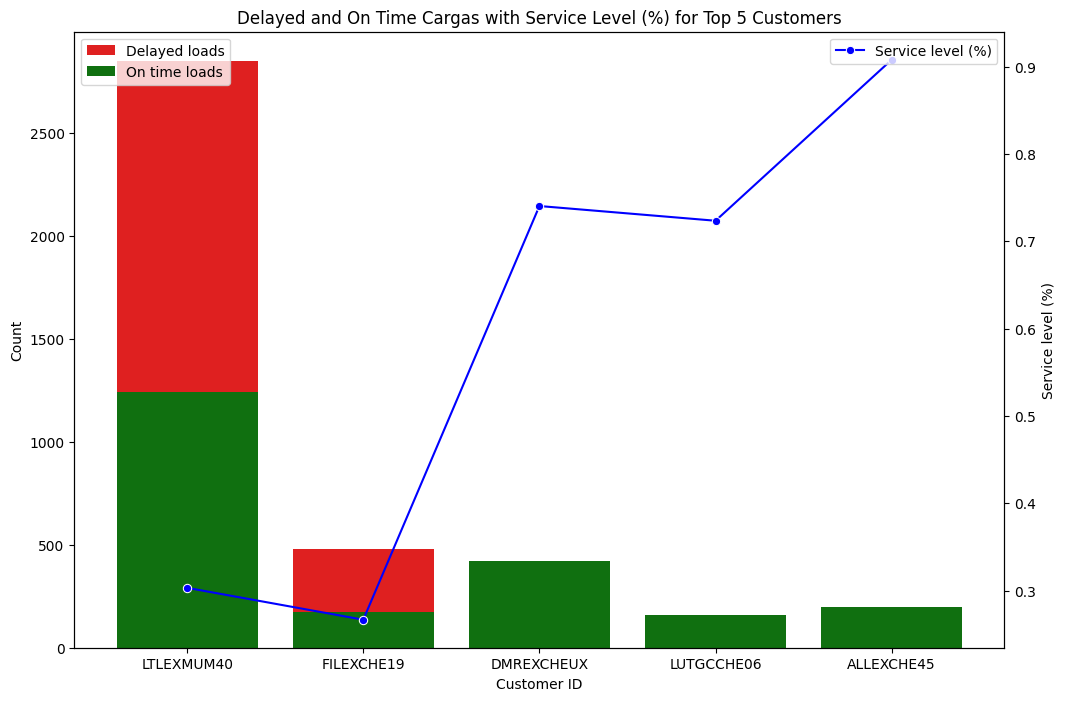

In [264]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1.head(), x='customerID', y='Delayed', color='red', label='Delayed loads', ax=ax1)
sns.barplot(data=piv1.head(), x='customerID', y='On time', color='green', label='On time loads', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1.head(), x='customerID', y='Service level (%)', color='blue', marker='o', ax=ax2, label='Service level (%)')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Count')
ax1.legend(loc='upper left')
ax2.set_ylabel('Service level (%)')
ax2.legend(loc='upper right')
plt.title('Delayed and On Time Cargas with Service Level (%) for Top 5 Customers')
plt.show()

Con este análisis queda claro que el cliente que mayor número de cargas supone para la compañía con un 60.17%, recibe el segundo peor nivel de servicio de nuestro top 5 mejores clientes. Experimentó retraso en la entrega en 2851 ocasiones, solo en el 30.3% de cargas transportadas con nosotros recibió un nivel de servicio aceptable (Entendiendo nivel de servicio como sin retraso en la fecha de entrega planeada). Todos los clientes de nuestro top 5 han percibido demoras en la operación.

De este análisis se pueden desprender la tasa de retiro de los clientes en el tiempo, por ejemplo, o la reducción de la demanda de nuestros servicios en el tiempo. Por ahora no revisaremos cómo ha ido disminuyendo la cantidad de interés de nuestros clientes por nuestra empresa. Sino un análisis de capacidad para conocer si la flota de camiones, que al parecer es bastante alta, presenta problemas de cobertura o si por el contrario el seguimiento de las operaciones por parte de los despachadores a cargo, no está siendo eficiente y distintos conductores no tienen una corrección de ruta a tiempo.

### Nivel de servicio por conductor

In [265]:
piv1=df.pivot_table(index='Driver_Name', columns='delay', aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)
piv1=piv1.loc[piv1['Total']>10] #los que han llevado mayor cantidad de cargas

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning:

is_categorical_dtype

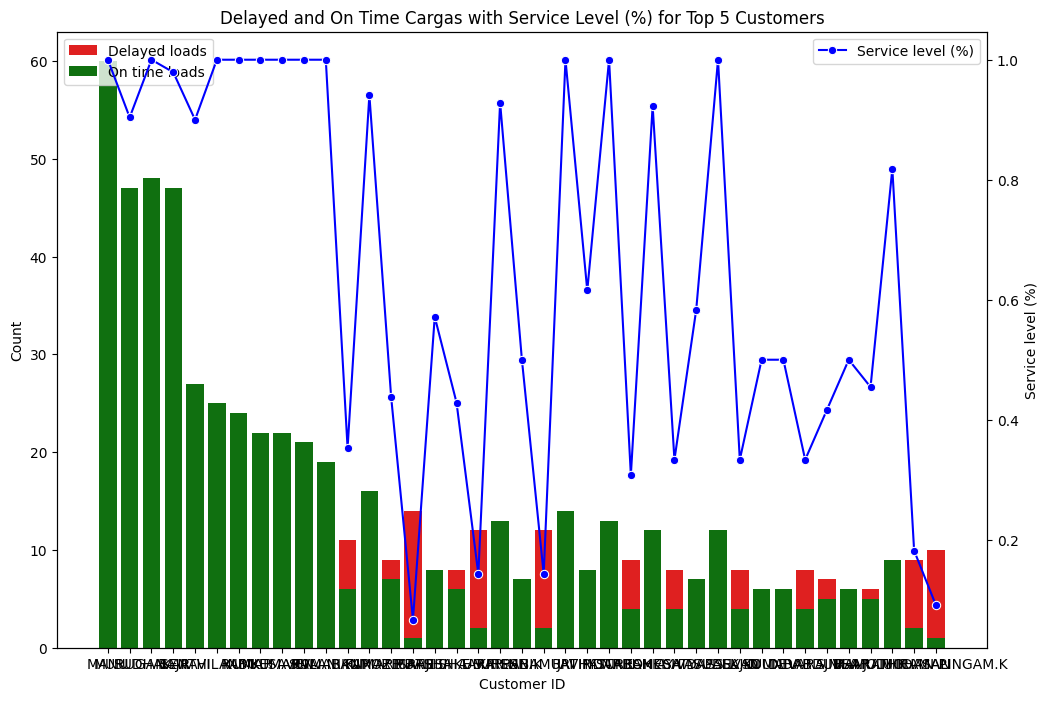

In [266]:
fig, ax1 = plt.subplots(figsize=(12, 8))
sns.barplot(data=piv1, x='Driver_Name', y='Delayed', color='red', label='Delayed loads', ax=ax1)
sns.barplot(data=piv1, x='Driver_Name', y='On time', color='green', label='On time loads', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=piv1, x='Driver_Name', y='Service level (%)', color='blue', marker='o', ax=ax2, label='Service level (%)')
ax1.set_xlabel('Customer ID')
ax1.set_ylabel('Count')
ax1.legend(loc='upper left')
ax2.set_ylabel('Service level (%)')
ax2.legend(loc='upper right')
plt.title('Delayed and On Time Cargas with Service Level (%) for Top 5 Customers')
plt.show()

Si bien es cierto, no en todas las cargas se conoce el conductor asignado, al menos en este análisis de 3440 cargas, nos permite ver que el top 10 conductores que más cargas transportan tienen un nivel de servicio por encima del 90%. Estos datos los puede utilizar la empresa como input para bonificaciones, programas de fidelización del empleado, entre otros. En el caso de los conductores de bajo nivel de servicio es adecuado conocer qué despachador monitorea su operación y hacer un seguimiento más cercanos de las decisiones operativas que se toman durante la ejecución de la ruta, con el fin de determinar qué genera los retrasos y que acciones rápidas de reprogramación o para evitar retrasos no se están tomando a tiempo.

### Análisis de materiales transportados por los conductores

In [267]:
piv1=df.pivot_table(index='Material Shipped', columns= "delay", aggfunc='size', fill_value=0).reset_index()
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['On time']/piv1['Total']
piv1 = piv1.sort_values(by='Total', ascending=False)
piv1['freq_relativa']=piv1['Total']/6800
piv1['acum']=piv1['freq_relativa'].cumsum()
piv1=piv1.loc[piv1['Total']>30]
piv1

delay,Material Shipped,Delayed,On time,Total,Service level (%),freq_relativa,acum
86,AUTO PARTS,1089,407,1496,0.272059,0.220000,0.220000
476,GRS STARTER,216,35,251,0.139442,0.036912,0.256912
785,M70 STARTER MOTOR 12V 0.9KW,126,89,215,0.413953,0.031618,0.288529
365,EMPTY TRAYS,124,47,171,0.274854,0.025147,0.313676
1034,SIA114 12V 70A ALTERNATOR,104,55,159,0.345912,0.023382,0.337059
1082,SPARE PARTS AUTOMOBILE,110,44,154,0.285714,0.022647,0.359706
59,A114 Alternator(New Versa),60,86,146,0.589041,0.021471,0.381176
386,Empty trays,64,29,93,0.311828,0.013676,0.394853
351,EMPTY BIN,23,41,64,0.640625,0.009412,0.404265
1065,SOLENOID SWITCH,40,12,52,0.230769,0.007647,0.411912


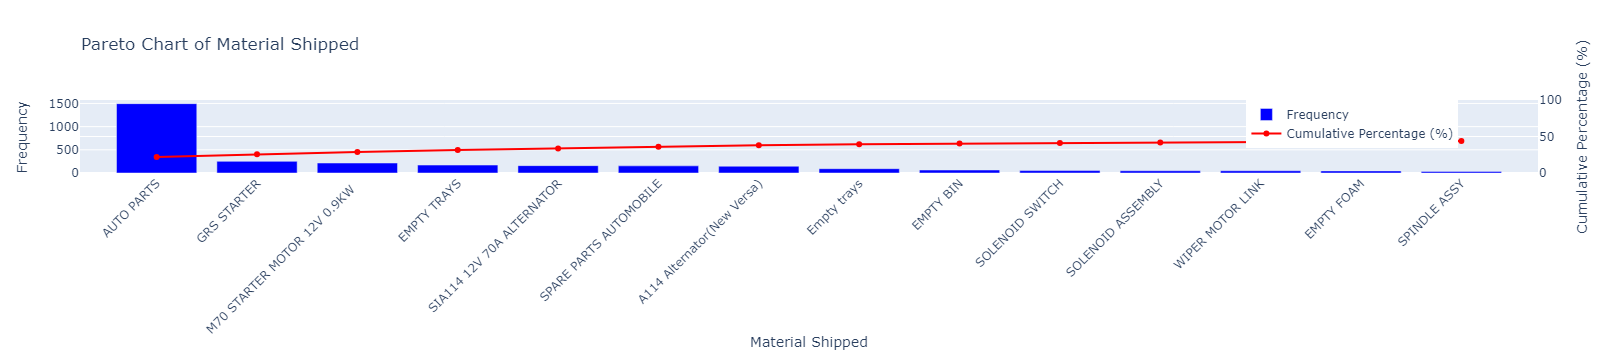

In [268]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=piv1['Material Shipped'],
    y=piv1['Total'],
    name='Frequency',
    marker_color='blue'
))

fig.add_trace(go.Scatter(
    x=piv1['Material Shipped'],
    y=piv1['acum'] * 100,
    mode='lines+markers',
    name='Cumulative Percentage (%)',
    yaxis='y2',
    line=dict(color='red')
))

fig.update_layout(
    title='Pareto Chart of Material Shipped',
    xaxis_title='Material Shipped',
    yaxis_title='Frequency',
    yaxis2=dict(
        title='Cumulative Percentage (%)',
        overlaying='y',
        side='right',
        range=[0, 100]
    ),
    xaxis_tickangle=-45,
    legend=dict(x=0.8, y=1.0)
)

fig.show()

Con este resultado, concluimos que las auto parts presentan alto nivel de demanda en la empresa y de los 1496 transportes que se han realizado de este tipo de carga, solo el 27.2% ha sido entregado a tiempo. Cualquier modificación que se realice al flujo actual de operación se debe testear/revisar/verificar durante el envío de este tipo de carga, para conocer si el cambio surgió efecto y permite mejorar el tiempo de entrega de las 'autoparts'. En este punto también se pueden proponer mejoras en cuanto al tipo de vehículo que está transportando este material, puede ser requerido alguno que genere entregas más expeditas, de menor tamaño, como un cargo van y no vehículos de 40 o 53 pies, cuya maniobra en algunos lugares puede resultar costosa, lenta y peligrosa.

### 2. Preparación de la serie de tiempo

En este estudio, no tendremos en cuentas las sugerencias de mejoras planteadas durante el análisis exploratorio. Sino que observaremos el análisis de capacidad/demanda en el tiempo, que parece ser el verdadero problema de raíz de la empresa. No en la cantidad de conductores y camiones disponibles, pero en la planeación, ejecución y seguimiento de las rutas. Para eso prepararemos nuestros datos en el formato que una serie de tiempo lo requiere.

### Cambios en el tiempo del nivel de servicio

In [284]:
piv1=df.pivot_table(index='BookingID_Date', values= 'BookingID',columns='delay',aggfunc='size', fill_value=0).reset_index()
piv1['BookingID_Date'] = pd.to_datetime(piv1['BookingID_Date'])
piv1 = piv1.sort_values('BookingID_Date')
piv1['Total']=piv1['Delayed']+piv1['On time']
piv1['Service level (%)']=piv1['Delayed']/piv1['Total']*100
piv1['BookingID_Date'] = pd.to_datetime(piv1['BookingID_Date'])
piv1 = piv1.sort_values('BookingID_Date')

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



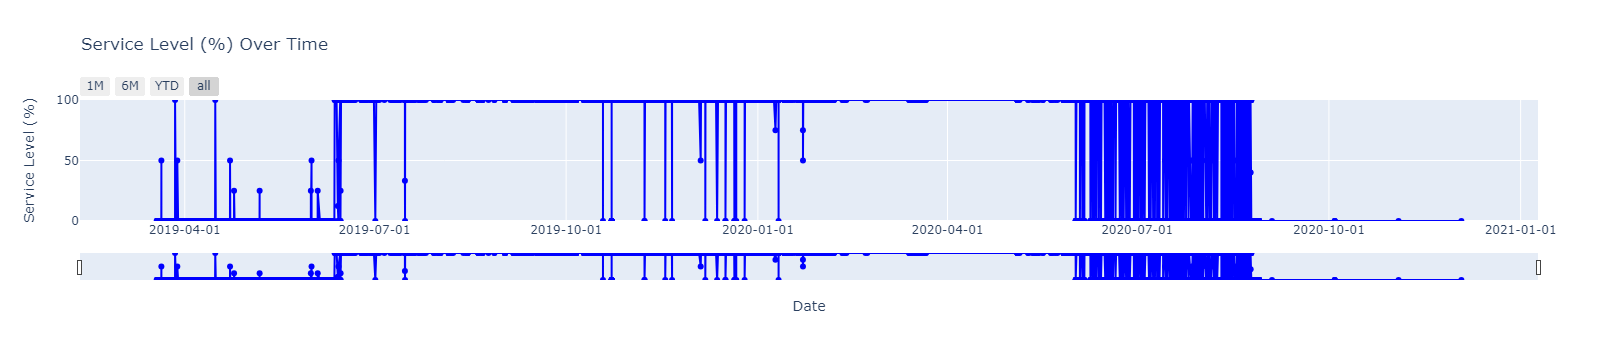

In [285]:
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=piv1['BookingID_Date'],
    y=piv1['Service level (%)'],
    mode='lines+markers',
    name='Service level (%)',
    line=dict(color='blue'),
    marker=dict(size=6)
))
fig.update_layout(
    title='Service Level (%) Over Time',
    xaxis_title='Date',
    yaxis_title='Service Level (%)',
    yaxis=dict(
        title='Service Level (%)',
        range=[0, 100],
        autorange=False
    ),
    xaxis=dict(
        title='Date',
        tickformat='%Y-%m-%d',
        rangeselector=dict(
            buttons=list([
                dict(count=1, label='1M', step='month', stepmode='backward'),
                dict(count=6, label='6M', step='month', stepmode='backward'),
                dict(count=1, label='YTD', step='year', stepmode='todate'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    legend=dict(x=0.8, y=1.0)
)

fig.show()

Se observa en esta serie de tiempo que una primera parte del tiempo la empresa mantenía en mayor medida niveles de servicios bajos, donde el período de abril a julio de 2019 la mayor cantidad de casos presentaban niveles de servicios por debajo del 50%. En una segunda instancia, desde Julio hasta apróximadamante mayo de 2020, el nivel de servicio estuvo rondando en gran parte de los casos un 100%. Mientras que una tercera etapa de Mayo en adelante, existe mayor variabilidad entre el cumplimiento de nivel de servicio.

### Cargas reservadas al día por los despachadores

In [274]:
piv1=df.pivot_table(index='BookingID_Date', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
piv1['BookingID_Date'] = pd.to_datetime(piv1['BookingID_Date'])
piv1 = piv1.sort_values('BookingID_Date')

,BookingID_Date,BookingID
0,2019-03-18 12:19:22,1
1,2019-03-18 16:24:18,1
2,2019-03-18 16:56:02,1
3,2019-03-18 17:03:13,1
4,2019-03-18 17:25:43,1
...,...,...
5923,2020-10-03 18:26:21,1
5924,2020-10-03 19:05:53,1
5925,2020-10-03 20:05:28,1
5926,2020-11-03 10:12:17,1


C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



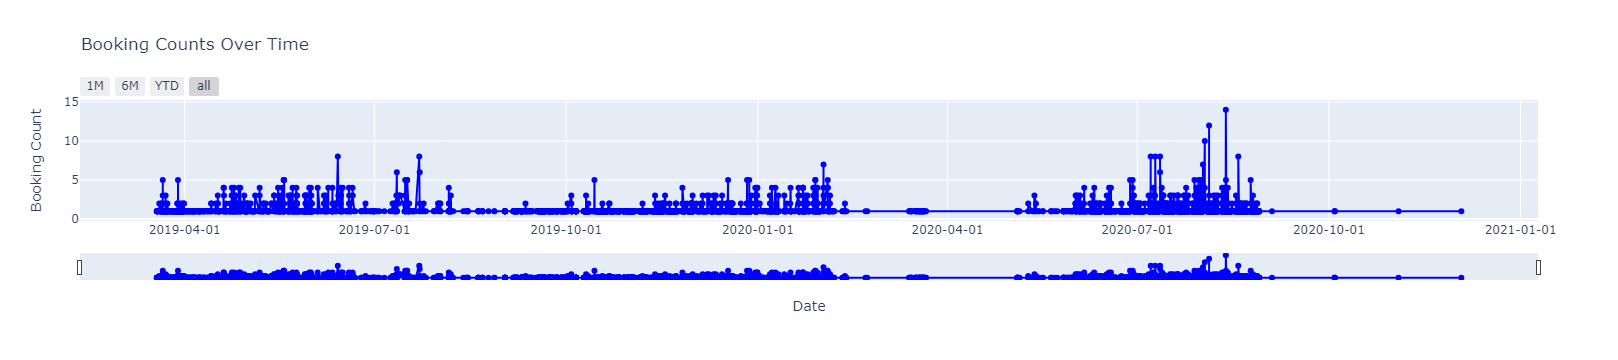

In [275]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=piv1['BookingID_Date'],
    y=piv1['BookingID'],
    mode='lines+markers',
    name='Booking Count',
    line=dict(color='blue'),
    marker=dict(size=6)
))

fig.update_layout(
    title='Booking Counts Over Time',
    xaxis_title='Date',
    yaxis_title='Booking Count',
    xaxis=dict(
        title='Date',
        tickformat='%Y-%m-%d',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1M',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6M',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='todate'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    yaxis=dict(
        title='Booking Count',
        autorange=True
    )
)
fig.show()

Esta es la primera serie de tiempo propuesta para el análisis. Corresponde al número de cargas reservadas por día en el período de un año y casi 9 meses de nuestra base de datos. Hay 3 etapas en esta serie de tiempo, lo decimos de esa forma por el período de Agosto a Noviembre de 2019 y el de enero a mayo de 2020, que separan la serie de tiempo en 3 momentos de análisis.

Observamos que aunque en la primera etapa donde el nivel de servicio fue bajo alto número de cargas eran reservadas al día, esta mala tasa de servicio no parece impactar visualmente el número de cargaas posibles reservadas al día por la compañía en la segunda etapa, pero sí posible la confiabilidad de los usuarios sobre ella. En una tercera etapa, el número de cargas parece aumentar en varias ocasiones con respecto a los dos primeros períodos.

*Considerando que son cargas contratadas puede ser porque en el segundo periodo se mejoró el nivel de servicio y por ende la confiabilidad de los clientes sobre las operaciones.*

### Número de cargas planeadas por entregar por día

In [294]:
piv1=df.pivot_table(index='Planned_ETA', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
piv1['Planned_ETA'] = pd.to_datetime(piv1['Planned_ETA'])
piv1 = piv1.sort_values('Planned_ETA')

,Planned_ETA,BookingID
6215,1899-12-30 04:06:00,1
6216,1899-12-30 08:58:00,1
0,2019-03-19 11:45:22,1
1,2019-03-19 15:47:43,1
2,2019-03-19 16:54:13,1
...,...,...
6210,2020-10-07 22:26:21,1
6211,2020-10-07 23:05:53,1
6212,2020-10-08 00:05:28,1
6213,2020-11-07 14:12:17,1


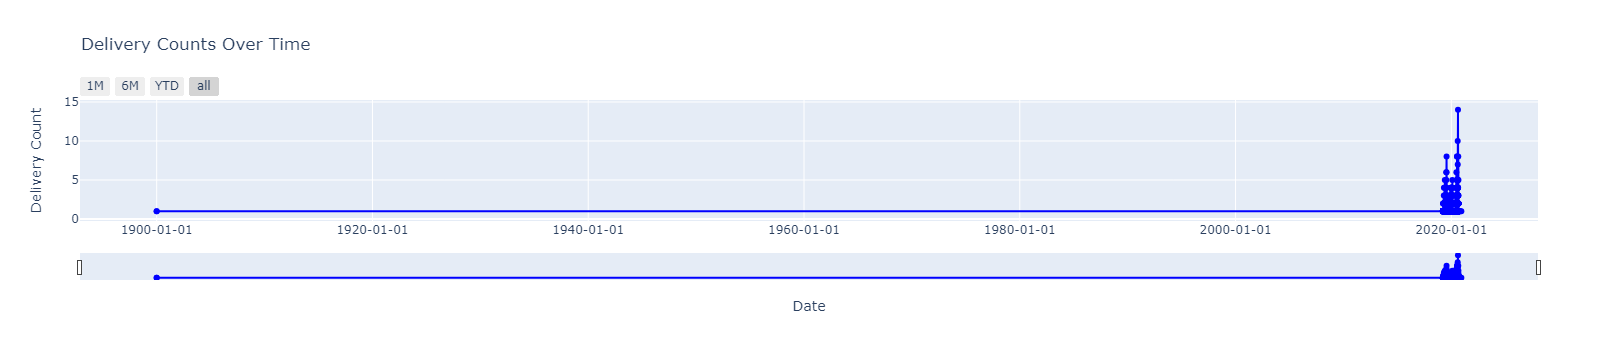

In [291]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=piv1['Planned_ETA'],
    y=piv1['BookingID'],
    mode='lines+markers',
    name='Delivery Count',
    line=dict(color='blue'),
    marker=dict(size=6)
))

fig.update_layout(
    title='Delivery Counts Over Time',
    xaxis_title='Date',
    yaxis_title='Delivery Count',
    xaxis=dict(
        title='Date',
        tickformat='%Y-%m-%d',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1M',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6M',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='todate'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    yaxis=dict(
        title='Delivery Count',
        autorange=True
    )
)
fig.show()

En este punto observamos un comportamiento extraño en la serie de tiempo y notamos que hay dos valores que escaparon de la limpieza de dactos en la columna de "Planned_ETA" por lo cual los eliminaremos. Porque no solo se presentan mal calculados en esta columna, sino tambien en el "actual_eta" y "trip_start_date", por lo que resulta complicado revisar directamente, sin un análisis de coordenadas, si realmente son cargas demoradas y porque directamete nuestra columna de referencia de entrega a tiempo es la columna de "Planned_ETA".

In [299]:
df['Planned_ETA'] = pd.to_datetime(df['Planned_ETA'])
df['BookingID_Date'] = pd.to_datetime(df['BookingID_Date'])
min_booking_date = df['BookingID_Date'].min()
df=df.drop(df.loc[df['Planned_ETA'] < min_booking_date].index) #Continuamos con 6798 datos

C:\Users\karen\anaconda3\envs\myenv\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



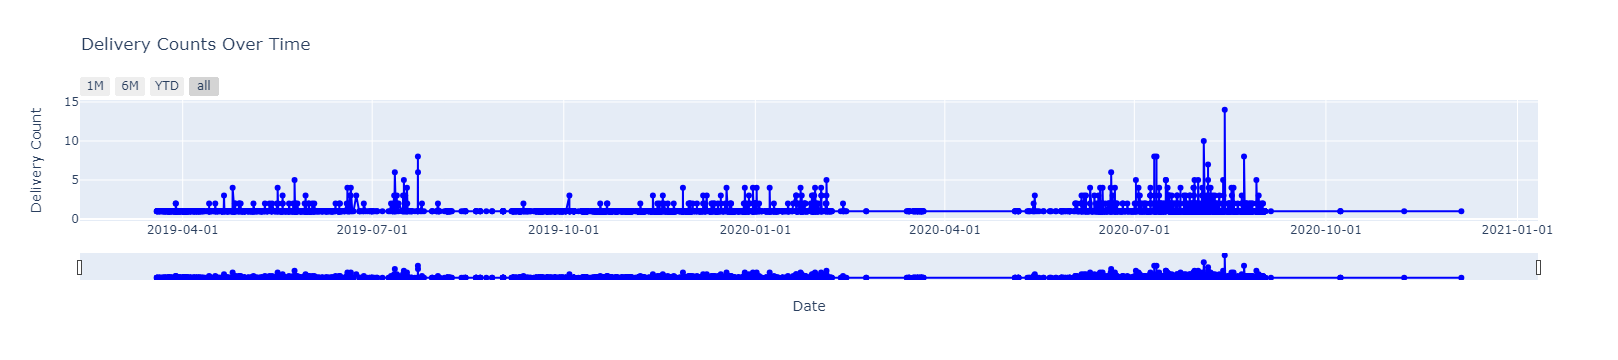

In [301]:
piv1=df.pivot_table(index='Planned_ETA', values= 'BookingID',aggfunc='count', fill_value=0).reset_index()
piv1['Planned_ETA'] = pd.to_datetime(piv1['Planned_ETA'])
piv1 = piv1.sort_values('Planned_ETA')

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=piv1['Planned_ETA'],
    y=piv1['BookingID'],
    mode='lines+markers',
    name='Delivery Count',
    line=dict(color='blue'),
    marker=dict(size=6)
))

fig.update_layout(
    title='Delivery Counts Over Time',
    xaxis_title='Date',
    yaxis_title='Delivery Count',
    xaxis=dict(
        title='Date',
        tickformat='%Y-%m-%d',
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1M',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6M',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                     label='YTD',
                     step='year',
                     stepmode='todate'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(visible=True)
    ),
    yaxis=dict(
        title='Delivery Count',
        autorange=True
    )
)
fig.show()

Como era de esperarse, a mayor número de cargas reservadas, mayor es la cantidad de cargas que se planean entregar, comportamiento resultante en el período 3. Este punto es super importante, porque supone el análisis de la capacidad que tengo disponible, lo que ya gasté de recurso y la nueva demanda que surge a diario. Debo poder con mi parte operativa, reservar, negociar, monitorear y cobrar facturas de las cargas que entrego. Si los depsachadores realizan todo esto en simultáneo y supone un problema en la completitud del servicio existe un problema de capacidad operativa por solucionar. Este análisis de serie de tiempo nos podría apoyar en la estimación de esa demanada que requiero por día de conductores y despachadores.

## 3. Conclusiones

Esto del análisis de las fechas de entrega y reserva de carga, además debe estar acompañado con un análisis en el tiempo de la cantidad de camiones y conductores con que cuento para cada etapa, en su retención, adquisición o despido/venta del recurso. Esto podría suponer la integración de distintas series de tiempo que influyen la una sobre la otra. La cantidad de cargas reservadas con respecto a la cantidad de cargas que se deben entregar por día y la cantidad de recursos que utilizo y requiero para ir cumpliendo con esas entregas. 

Una buena organización y planeación de este aspecto, me permitiría entonces cumplir de mejor manera con el nivel de servicio de mis clientes, asegurar la confiabilidad que tengan sobre mi operación y mantener la rentabilidad y competitividad en el mercado. En el caso particular de mi trabajo, es este tal cual el enfoque al que queremos apuntarle. Conocer el estado actual de su operación, proponer mejoras en la planeación de las rutass, ejecución en la búsqueda de cargas y el seguimiento por parte del despachador, de manera que se puedan generar alternativa por si es necesario reprogramar o cancelar una carga o se mantenga un seguimiento más fuerte sobre el driver que permita disminuir el desperdicio de tiempo.